In [1]:
import duckdb as db
import pandas as pd
from generate_db_data import generate_benefit_balances, generate_benefit_points, generate_client_data

## Предисловие
- Хотя в исходных заданиях не требовалось писать код для генерации данных, я решил, что это отличная возможность хотя бы немного продемонстрировать свои навыки программирования. Кроме того, работать гораздо удобнее, когда есть реальные данные под рукой. Вы можете ознакомиться с моим кодом в файле generate_db_data.py;
- В некоторых заданиях требовалось написать SQL-запросы. Чтобы использовать синтаксис SQL без необходимости поднимать базу данных, я решил воспользоваться библиотекой duckdb, которая позволяет обращаться к датафреймам с помощью SQL-синтаксиса. Таким образом, у вас есть возможность протестировать мой SQL-скрипт;
- Во втором задании я позволил себе расширить количество метрик, которое можно построить на основе данные таблицы `client`

In [20]:
# Параметры генерации для generate_benefit_balances
number_of_clients = 100
start_account_balance_date, end_account_balance_date=  "2024-01-01", "2024-01-31"
min_balance, max_balance = 0, 1_000_000
no_change_prob = 0.3

# Параметры генерации для generate_benefit_points
max_transactions_per_day = 10
probability_of_mismatch = 0.1

# Параметры генерации для generate_client_data
start_open_date = "2024-01-01"
end_open_date = "2024-11-10"

# Генерируем данные
benefit_balances = generate_benefit_balances(
    number_of_clients,
    start_account_balance_date, end_account_balance_date,
    min_balance, max_balance,
    no_change_prob
)
benefit_points = generate_benefit_points(
    benefit_balances,
    max_transactions_per_day,
    probability_of_mismatch
)

client = generate_client_data(
    number_of_clients,
    start_open_date,
    end_open_date
)

## Задание 1

### Исходные данные
Даны 3 таблицы со следующими полями:
1. `benefit_balances` – данные об остатках баллов клиентов на начало каждого дня:
    - `CODE`       –  идентификатор клиента;
    - `BAL_DATE`   –  дата;
    - `VALUE`      –  остаток баллов клиента code  на дату  `BAL_DATE`;
2.	`benefit_points`   –  данные о всех транзакциях начислений и трат баллов
    - `CODE`       - идентификатор клиента
    - `DIRECTION`  - принимает два значения: 1 - начисление и 0 - трата
    - `CREATED_AT` - дата начисления/траты
    - `CUST_SUM`   - сумма начисления/траты
3.	`calendar` – календарь (вспомогательная, можно обойтись без нее)
    - `START_DATE` – список всех дат со дня основания Точки
### Задача
Написать SQL-запрос, который будет проверять, что таблицы `benefit_balances` и `benefit_points` согласованы между собой, т.е. для каждого клиента и всегда выполняется:
`Остаток(t) = Остаток(t-1) + Начисления(t-1) - Траты(t-1)`

In [7]:
# ЗАДАНИЯ №1
mismatches = db.sql(
    """
    with daily_delta as (
    select
        CODE,
        cast(CREATED_AT as date) as AT,
        sum(case when DIRECTION = 1 then CUST_SUM when DIRECTION = 0 then -CUST_SUM else 0 end) DELTA
    from benefit_points
    group by CODE, cast(CREATED_AT as date)
    ),
    balances as (
    select
        CODE,
        BAL_DATE,
        VALUE,
        lag(VALUE) over (partition by CODE ORDER BY BAL_DATE) LAG_VALUE,
        VALUE - lag(VALUE) over (partition by CODE ORDER BY BAL_DATE) DIFF_BALANCES,
    from benefit_balances
    )
    
    select b.CODE,
           BAL_DATE,
           DELTA - DIFF_BALANCES MISMATCH
    from balances b
      left join daily_delta d on b.CODE = d.CODE and b.BAL_DATE = d.AT
    where 1=1
      and LAG_VALUE is not null
      and (DIFF_BALANCES - DELTA) <> 0
    order by at
    """
).to_df()

In [8]:
print(f"Исходная доля расхождений: {0.1}")
print(f"Доля расхождений полученная из скрипта: {round(mismatches.shape[0] / benefit_balances.shape[0], 1)}")

Исходная доля расхождений: 0.1
Доля расхождений полученная из скрипта: 0.1


## Задание 2

### Исходные данные
Даны 3 таблицы со следующими полями:
1. `client` – данные о клиентах
    - `CODE` - идентификатор клиента
    - `OPEN_DATE` – дата открытия счета
    - `FIRST_WORKING_DATE` – дата первой операции по счету (`null`, если операций не было)
### Задача
Точке важно, чтобы клиент не только открывал у нас счет, но и начал работать по нему (мы называем это «рождением» клиента). Предложи расчет метрики, которая показывала бы ситуацию с рождением.

### Решение
Метрикой, отражающей ситуацию с «рождением» клиентов, является коэффициент активации (`Activation Rate`). Он показывает процент клиентов, которые после открытия счета начали по нему работать, то есть совершили первую операцию. Важно, так же рассматривать данную метрику в динамике. Для учета динамики необходимо рассчитывать эту метрику по выбранным периодам времени.

```
Коэффициент активации в периоде t (%) = [Количество клиентов, открывших счет в периоде t и совершивших первую транзакцию в периоде t / Общее количество клиентов, открывших счет в периоде t] × 100%
```

Коэффициент активации позволяет измерить эффективность ваших усилий по вовлечению клиентов. Если этот показатель низкий, это может свидетельствовать о том, что процесс адаптации сложен или запутан, и пользователи прекращают взаимодействие, не завершив ключевые этапы. Например, если коэффициент активации составляет 25%, это означает, что 75% клиентов, открывших счет в банке, не доходят до стадии активного использования, что указывает на значительные возможности для улучшения.

In [37]:
# ЗАДАНИЯ №2
# Для примера использовал quarter. Можно попробовать использовать day, week, month, year 
activation_rate_by_quarter = db.sql(
    """
    SELECT
        DATE_TRUNC('quarter', OPEN_DATE) AS period,
        COUNT(*) AS total_opened_accounts,
        COUNT(*) FILTER (
            WHERE FIRST_WORKING_DATE IS NOT NULL
              AND DATE_TRUNC('quarter', FIRST_WORKING_DATE) = DATE_TRUNC('quarter', OPEN_DATE)
        ) AS activated_in_same_period,
        ROUND(
            (COUNT(*) FILTER (
                WHERE FIRST_WORKING_DATE IS NOT NULL
                  AND DATE_TRUNC('quarter', FIRST_WORKING_DATE) = DATE_TRUNC('quarter', OPEN_DATE)
            ) * 100.0) / NULLIF(COUNT(*), 0),
            2
        ) AS activation_rate_percentage
    FROM client
    GROUP BY DATE_TRUNC('quarter', OPEN_DATE)
    ORDER BY period
    """
).to_df()

activation_rate_by_quarter

,period,total_opened_accounts,activated_in_same_period,activation_rate_percentage
0,2024-01-01,27,1,3.70
1,2024-04-01,25,5,20.00
2,2024-07-01,34,15,44.12
3,2024-10-01,14,11,78.57


<Axes: xlabel='period'>

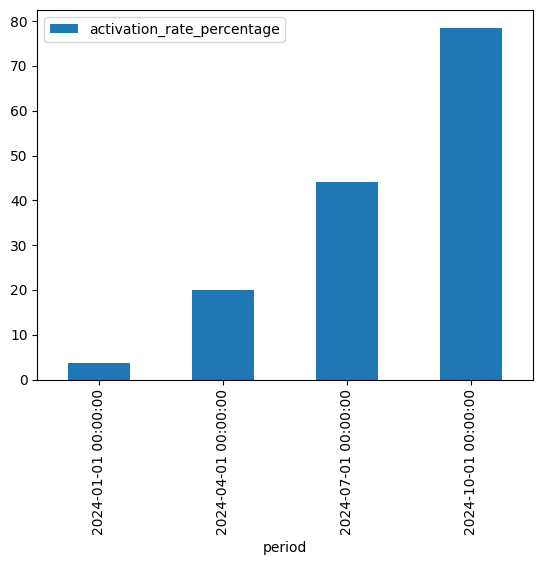

In [46]:
activation_rate_by_quarter.plot.bar(x='period', y='activation_rate_percentage')

На основе данных таблицы `client` возможно также построить и другие метрики, приведу некоторые из них:
#### 1. Время до активации клиента за период
**Описание:** Эта метрика показывает среднее количество дней, которое проходит с даты открытия счёта (`OPEN_DATE`) до первой операции (`FIRST_WORKING_DATE`) за период.

In [53]:
monthly_median_days_to_activation = db.sql(
    """
    SELECT
        DATE_TRUNC('month', OPEN_DATE) AS period,
        MEDIAN(DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE)) AS median_days_to_activation
    FROM client
    WHERE FIRST_WORKING_DATE IS NOT NULL
    GROUP BY DATE_TRUNC('month', OPEN_DATE)
    ORDER BY period;
    """
).to_df()

monthly_median_days_to_activation.head(5)

,period,median_days_to_activation
0,2024-01-01,174.5
1,2024-02-01,136.5
2,2024-03-01,128.5
3,2024-04-01,94.0
4,2024-05-01,71.5


#### 2. Процент клиентов без активности за период
**Описание:** Доля клиентов, которые открыли счёт, но не провели ни одной операции за период (т.е., `FIRST_WORKING_DATE = NULL`).

In [57]:
monthly_inactive_client_rate = db.sql(
    """   
    SELECT
        DATE_TRUNC('month', OPEN_DATE) AS period,
        COUNT() inactive_client_rate
    FROM client
    WHERE FIRST_WORKING_DATE IS NULL
    GROUP BY DATE_TRUNC('month', OPEN_DATE)
    ORDER BY period;
    """
).to_df()

monthly_inactive_client_rate.head(5)

,period,inactive_client_rate
0,2024-01-01,1
1,2024-06-01,1
2,2024-07-01,1
3,2024-08-01,1
4,2024-09-01,2


#### 3. Процент клиентов, активированных в первые X дней за период
Описание: Процент клиентов, которые начали пользоваться счётом в течение первых X дней после его открытия. Например, можно рассчитать для 7, 14 и 30 дней.

In [69]:
activation_within_x_days = db.sql(
    """   
    SELECT
        DATE_TRUNC('quarter', OPEN_DATE) AS period,
        ROUND(COUNT(CASE WHEN DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE) <= 7 THEN 1 END) * 100.0 / COUNT(*), 2) AS activation_within_7_days,
        ROUND(COUNT(CASE WHEN DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE) <= 14 THEN 1 END) * 100.0 / COUNT(*), 2) AS activation_within_14_days,
        ROUND(COUNT(CASE WHEN DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE) <= 30 THEN 1 END) * 100.0 / COUNT(*), 2) AS activation_within_30_days
    FROM client
    WHERE FIRST_WORKING_DATE IS NOT NULL
    GROUP BY DATE_TRUNC('quarter', OPEN_DATE)
    ORDER BY period;
    """
).to_df()

activation_within_x_days

,period,activation_within_7_days,activation_within_14_days,activation_within_30_days
0,2024-01-01,0.00,0.00,3.85
1,2024-04-01,0.00,4.17,20.83
2,2024-07-01,13.33,20.00,40.00
3,2024-10-01,72.73,72.73,90.91


#### 4. Среднее время от открытия счёта до первой операции среди активных клиентов за период
**Описание**: Среднее количество дней от открытия счёта до первой операции, только для клиентов, которые активировались (первая операция была выполнена) за период.

In [70]:
median_days_to_activation_within_x_days = db.sql(
    """
    SELECT
        DATE_TRUNC('quarter', OPEN_DATE) AS period,
        MEDIAN(DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE))
            FILTER (WHERE DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE) <= 7) AS median_days_to_activation_within_7_days,
        MEDIAN(DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE))
            FILTER (WHERE DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE) <= 14) AS median_days_to_activation_within_14_days,
        MEDIAN(DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE))
            FILTER (WHERE DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE) <= 30) AS median_days_to_activation_within_30_days
    FROM client
    WHERE FIRST_WORKING_DATE IS NOT NULL
    GROUP BY DATE_TRUNC('quarter', OPEN_DATE)
    ORDER BY period;
    """
).to_df()

median_days_to_activation_within_x_days

,period,median_days_to_activation_within_7_days,median_days_to_activation_within_14_days,median_days_to_activation_within_30_days
0,2024-01-01,NaN,NaN,28.0
1,2024-04-01,NaN,8.0,21.0
2,2024-07-01,0.0,0.5,15.0
3,2024-10-01,0.5,0.5,1.0


#### 5. Распределение времени активации (сегментация по времени) за период
**Описание**: Сегментация клиентов по времени активации: сколько клиентов активировались в течение 7 дней, 14 дней, 30 дней и более.

In [72]:
db.sql(
    """
SELECT 
    DATE_TRUNC('quarter', OPEN_DATE) AS period,
    COUNT(CASE WHEN DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE) <= 7 THEN 1 END) AS activated_within_7_days,
    COUNT(CASE WHEN DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE) > 7 AND DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE) <= 14 THEN 1 END) AS activated_within_14_days,
    COUNT(CASE WHEN DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE) > 14 AND DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE) <= 30 THEN 1 END) AS activated_within_30_days,
    COUNT(CASE WHEN DATEDIFF('day', OPEN_DATE, FIRST_WORKING_DATE) > 30 THEN 1 END) AS activated_after_30_days
FROM client
WHERE FIRST_WORKING_DATE IS NOT NULL
GROUP BY DATE_TRUNC('quarter', OPEN_DATE)
ORDER BY period;
    """
).to_df()

,period,activated_within_7_days,activated_within_14_days,activated_within_30_days,activated_after_30_days
0,2024-01-01,0,0,1,25
1,2024-04-01,0,1,4,19
2,2024-07-01,4,2,6,18
3,2024-10-01,8,0,2,1


## Задание 3

### Исходные данные

- Стоимость привлечения клиента (`CAC`) 100 руб.
- Доходность на платящего в месяц (`ARPPU`) 150 руб. 
- Каждый месяц мы теряем 50% базы (`churn rate`)

### Задача
- Вопрос 1: посчитать доход с 1 клиента
- Вопрос 2: улучшение какого из трех исходных показателей на 10% принесет больший эффект на доходность? 


----

#### Вопрос 1: Доход с одного клиента

Для расчета дохода с одного клиента сначала определим, как долго он будет приносить доход, учитывая месячную потерю 50% базы (`churn rate`). Поскольку клиентская база уменьшается на 50% каждый месяц, каждый клиент будет приносить доход по экспоненциальному убыванию.

1. **Средний срок жизни клиента (`ACL`)**
- Считаем, что вероятность ухода клиента составляет 50% каждый месяц.
- Средняя продолжительность "жизни" клиента (в месяцах) ACL = `1 / churn_rate = 1 / 0.5 = 2 месяца`.

2. **Доход с одного клиента (`LTV`)**:
- Доходность на одного платящего клиента в месяц ARPPU = `150 руб/мес`.
- Общий доход с одного клиента = `ARPPU * ACL`:
`Доход с одного клиента LTV = 150 руб/мес * 2 мес = 300 руб.`

**Ответ**: Доход с одного клиента составляет **300 руб.**

----

#### Вопрос 2: Какое улучшение на 10% из трех показателей принесет больший эффект на доходность?

#### Давайте рассмотрим каждый из показателей:

Понятие "улучшение" для трех параметров разное:
- Для `CAC` - это уменьшение;
- Для `ARPPU` - это увеличение;
- Для `Churn Rate` - это уменьшение;

1. **Уменьшение CAC на 10%**
- Текущий CAC = 100 руб.
- При уменьшении на 10%, новый CAC = 100 * (1 - 0.1) = 90 руб.
- Эффект: снижение стоимости привлечения клиента до 90 руб., но доход с клиента остаётся прежним (300 руб.).
- **Преимущество**: прибыль с клиента увеличивается до -> 300 руб. - 90 руб. = 210 руб. вместо 300 руб. - 100 руб. = 200 руб., что добавляет 10 руб. к прибыли с клиента.

2. **Увеличение ARPPU на 10%**
- Текущий ARPPU = 150 руб.
- При увеличении на 10%, новый ARPPU = 150 * (1 + 0.1) = 165 руб.
- Эффект: доход с клиента увеличивается до 165 руб./мес. * 2 мес. = 330 руб.
- **Преимущество**: общий доход с клиента вырастет до 330 руб., добавляя 30 руб. к доходности с клиента.

3. **Снижение churn rate на 10%**
- Текущий churn rate = 50% → средняя "жизнь" клиента 2 месяца.
- При снижении на 10%, новый churn rate = 50% * (1 - 0.1) = 45%.
- Новый средний срок жизни клиента = 1 / 0.45 = 2.22 месяца.
- Эффект: доход с клиента увеличивается до 150 * 2.22 = 333 руб.
- **Преимущество**: общий доход с клиента увеличивается до 333 руб., добавляя 33 руб. к доходности.

**Ответ**: Снижение churn rate на 10% принесет наибольший эффект на доходность** с одного клиента, так как оно увеличивает общий доход с клиента до **333 руб.**

